# Combined clustermap plots

## Overview

Here the results from Deseq2 are plotted in the form of clustermaps, taxonomic profiles of most abundant transporters and the log2FoldChange between groups.

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
sns.set(font_scale=1)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

## Functionality

In [2]:
def make_groupcols(df,cols,order=False,plot=False):
    group_lut = dict(zip(map(str, order),cols))
    group_colors = pd.Series([df.loc[x,"Group"] for x in df.index],index=df.index).map(group_lut)
    group_colors.name = "Sample group"
    if plot: 
        cat_fig,cat_ax = plot_custom_palette(cols,order,"Groups")
    return group_colors

In [3]:
def row_standardize(df):
    for i in df.index:
        df.loc[i,:] = (df.loc[i,:]-df.loc[i].min()) / df.loc[i].max()
    return df

def row_z_score(df):
    df_z = df.T
    df_z = (df_z-df_z.mean())/df_z.std()
    return df_z.T

In [4]:
def add_xtick_colors(row_axes,groupcols):
    for ax in row_axes:
        label_colors = []
        for tick in ax.get_xticklabels():
            label = tick.get_text()
            try: tick.set_color(groupcols.loc[label])
            except KeyError: tick.set_color("black")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 4})

In [5]:
def annotate_clustermap(ax,dec=1,minval=0.5):
    rows = ax.data.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind].index
    cols = ax.data.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind].columns
    # Extract reordered plotted data from ax
    data_norm = ax.data2d.loc[list(rows),list(cols)]
    # Reorder original data
    a = ax.data.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind]
    if dec == 0:
        a = a.astype(int)
    else:
        a = np.round(a,dec)
    for row in range(0,len(a.index)):
        for col in range(0,len(a.columns)):
            zval = data_norm.iloc[row,col]
            val = a.iloc[row,col]
            textcol="white"
            if zval == 1.0: 
                textcol = "black"
            elif zval >=0.95:
                textcol = "darkgrey"
            if val<=minval: continue
            ax.ax_heatmap.text(col+0.5,row+0.5,val,fontdict={'size':6,'color':textcol, 'horizontalalignment': 'center', 'verticalalignment': 'center'})
    return a,data_norm

In [202]:
def plot_custom_palette(cols,groups,name,axis=None):
    sns.set(font_scale=1)
    df = pd.DataFrame(data=[[1]*len(cols),groups],index=[name,"value"]).T
    fig = plt.figure(figsize=(0.25,2))
    ax = sns.barplot(data=df,x=name,y="value",palette=cols,ax=axis)
    ax.set_xlabel("");
    ax.set_ylabel("");
    ax.patch.set_facecolor("white");
    ax.set_xticklabels("");
    return fig,ax

In [7]:
def get_ntaxa(df,n=50):
    taxa = []
    for sample in df.columns:
        sample_sum =0
        df_sample_sort = df.sort_values(sample,ascending=False)
        for tax in df_sample_sort.index:
            sample_sum+=df_sample_sort.loc[tax,sample]
            taxa.append(tax)
            if sample_sum>=n: break
    taxa_sort = df.loc[set(taxa)].mean(axis=1).sort_values(ascending=False).index
    return taxa_sort

In [8]:
def get_quantile_transporters(df,q=0.5):
    '''Pair-wise sample differences are calculated for each transporter and transporters
    that have a maximum absolute difference above the 50% quantile across samples are kept'''
    data = df.groupby(level=0).sum()
    q_trans = []
    for sample in data.columns:
        sample_diff = abs(data.subtract(data[sample],axis=0))
        sample_diff_max = sample_diff.max(axis=1).sort_values(ascending=False)
        sample_diff_max_q = sample_diff_max.quantile(q=q)
        q_trans += list(sample_diff_max[sample_diff_max>=sample_diff_max_q].index)
    return list(set(q_trans))

## Load the data

### Load environmental data

In [9]:
env = pd.read_csv("data/LMO.time.series.metadata.csv", header=0, sep="\t", index_col=0)
env.rename(index = lambda x: str(x), inplace=True)

### Load the transporter data

This has been processed using the [process_data](process_data.ipynb) notebook.

In [10]:
mg_select_transcov_genes = pd.read_table("results/mg/select_trans_genes.tpm.tsv", index_col=0)
mg_select_transcov = pd.read_table("results/mg/select_trans.tpm.tsv", index_col=0)

mg_bac_select_transcov_genes = pd.read_table("results/mg/bac_select_trans_genes.tpm.tsv", index_col=0)
mg_bac_select_transcov = pd.read_table("results/mg/bac_select_trans.tpm.tsv", index_col=0)

In [11]:
mt_select_transcov_genes = pd.read_table("results/mt/select_trans_genes.tpm.tsv", index_col=0)
mt_select_transcov = pd.read_table("results/mt/select_trans.tpm.tsv", index_col=0)

mt_bac_select_transcov_genes = pd.read_table("results/mt/bac_select_trans_genes.tpm.tsv", index_col=0)
mt_bac_select_transcov = pd.read_table("results/mt/bac_select_trans.tpm.tsv", index_col=0)

### Load results from DESeq2

In [12]:
mg_deseq = pd.read_table("results/mg/deseq2.tab", header=0, sep="\t", index_col=7)
mt_deseq = pd.read_table("results/mt/deseq2.tab", header=0, sep="\t", index_col=7)

### Read sample groupings

In [13]:
mg_groups = pd.read_table("results/mg/samplegroups.tab", header=0, sep="\t", index_col=0)
mg_groups.rename(index=lambda x: str(x), inplace=True)
mt_groups = pd.read_csv("results/mt/samplegroups.tab", header=0, sep="\t", index_col=0)
mt_groups.rename(index=lambda x: str(x), inplace=True)

### Read selected transporters

In [14]:
transinfo = pd.read_table("results/selected_transporters_classified.tab")

In [15]:
cats = ["Anions","Cations","NH3 Nitrate","Urea","phosphate","phosphonate","AA peptide","nucleoside","carbohydrate"]

## Plots

### Plot group legend

In [16]:
mg_palette = sns.color_palette("YlGn",n_colors=2)+sns.color_palette("YlOrBr",n_colors=2)+sns.color_palette("PuBu",n_colors=2)

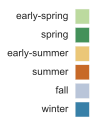

In [17]:
mg_groupcols = make_groupcols(mg_groups,mg_palette,order=["early-spring","spring","early-summer","summer","fall","winter"],plot=True)
plt.savefig("results/figures/mg_groups_legend.png",bbox_inches="tight",dpi=300)

In [18]:
mt_palette = [sns.color_palette("YlGn",n_colors=2)[1]]+sns.color_palette("YlOrBr",n_colors=2)+[sns.color_palette("PuBu",n_colors=2)[1]]

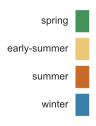

In [19]:
mt_groupcols = make_groupcols(mt_groups,mt_palette,order=["spring","early-summer","summer","winter"],plot=True)
plt.savefig("results/figures/mt_groups_legend.png",bbox_inches="tight",dpi=300)

### Plot category legend

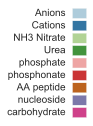

In [195]:
cat_cols = sns.color_palette("Paired", 6) + sns.color_palette("Dark2",4)[1:]
cat_lut = dict(zip(map(str,cats),cat_cols))
cat_lut["Other"] = "black"
cat_lut["Rare nutr"] = "grey"
plot_custom_palette(cat_cols,cats,name="Category");
plt.savefig("results/figures/substrate_category_legend.png",dpi=300,bbox_inches="tight")

### Plot clustermaps

#### Metagenome

In [21]:
mg_groups.Group.unique()
mg_sample_order = []
for g in "early-spring","spring","early-summer","summer","fall","winter":
    for s in mg_groups.loc[mg_groups.Group==g].index: mg_sample_order.append(s)

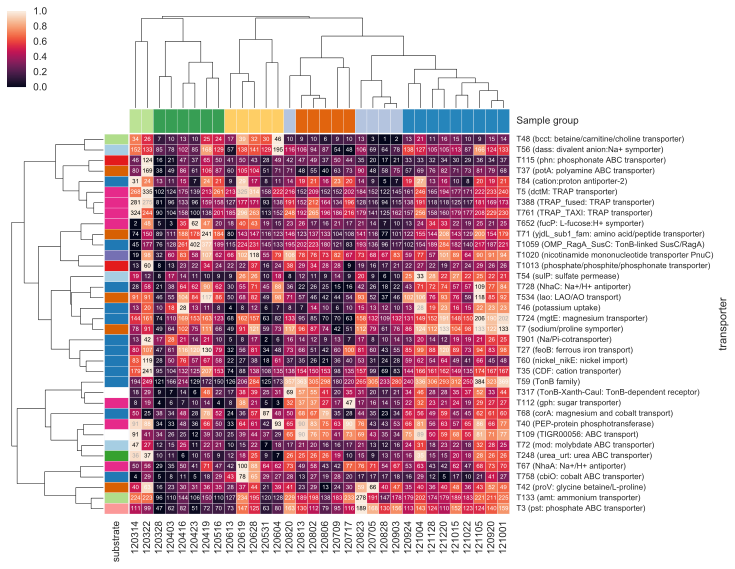

In [22]:
# Get transporters with an adjusted p-value < 0.05 in at least one of the Dseq2 comparisons
trans = set(mg_deseq.loc[mg_deseq.p_total_adj<0.05].index)
# Generate the data for plotting
clust_data = mg_bac_select_transcov.loc[trans][mg_groups.index]
clust_data = clust_data[mg_sample_order]

# Cluster transporters
row_linkage = linkage(pdist(clust_data, metric="correlation"), metric="correlation", method="complete")

# Annotate rows with the category legend colors
row_cols = pd.Series([mg_bac_select_transcov.loc[t,"substrate_category"] for t in trans],index=trans).map(cat_lut)
row_cols.name="substrate"

# Plot the clustermap
mg_ax = sns.clustermap(clust_data,method="average",metric="correlation",standard_scale=0, col_cluster=True, row_linkage=row_linkage,
               col_colors=mg_groupcols, row_colors=row_cols, figsize=(9,9),linewidths=0.2)
# Rotate the transporter labels
plt.setp(mg_ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
# Annotate the clustermap to add the percentage values to cells
a,data_norm = annotate_clustermap(ax=mg_ax, dec=0)
# Change transporter labels to include the second category substrate
ticklocs = []
ticklabels = []
for i,item in enumerate(a.index):
    ticklocs.append(i+0.5)
    ticklabels.append("{} ({})".format(item,mg_bac_select_transcov.loc[item,"name"]))
mg_ax.ax_heatmap.yaxis.set_ticks(ticklocs)
mg_ax.ax_heatmap.yaxis.set_ticklabels(ticklabels,fontsize=8);
plt.savefig("results/figures/mg_deseq_clustermap.png",dpi=300,bbox_inches="tight")

Extract subsets of transporters with similar abundance profiles and plot their taxonomic distribution

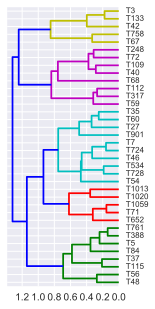

In [23]:
#TODO: Save this to a figure
threshold = 0.9 
g = pd.DataFrame(fcluster(row_linkage,criterion="distance",t=threshold),index=clust_data.index, columns=["group"])
plt.figure(figsize=(2,5))
dendrogram(row_linkage, color_threshold=0.9, orientation="left", labels=clust_data.index);

In [24]:
# Extract top 3 most abundant transporters per group
mg_plot_heat_clust = {}
for tg in g["group"].unique():
    tmp = clust_data.loc[g.loc[g["group"] == tg].index]
    mg_plot_heat_clust[tg] = list(tmp.mean(axis=1).sort_values(ascending=False).head(3).index)

In [25]:
mg_bac_select_fam_sum = mg_bac_select_transcov_genes.groupby(["fam","transporter","order"]).sum().reset_index()
mg_bac_select_trans_tax_mean = mg_bac_select_fam_sum.groupby(["transporter","order"]).mean().reset_index()

In [26]:
# Set cluster specific top 10 taxa
mg_plot_heat_clust_taxdict = {}
mg_plot_heat_clust_alltaxa = []
for clust in mg_plot_heat_clust.keys():
    # Get transporters for cluster
    transporters = mg_plot_heat_clust[clust]
    # Get summed taxonomic abundance for transporters
    r = mg_bac_select_trans_tax_mean.loc[mg_bac_select_trans_tax_mean.transporter.isin(transporters)]
    # Calculate mean abundance of taxa across all transporters and across all samples
    # Sort and take top 10
    _taxa = list(r.groupby("order").mean().mean(axis=1).sort_values(ascending=False).head(10).index)
    mg_plot_heat_clust_taxdict[clust] = _taxa
    mg_plot_heat_clust_alltaxa+=_taxa
    mg_plot_heat_clust_alltaxa = list(set(mg_plot_heat_clust_alltaxa))
len(mg_plot_heat_clust_alltaxa)

19

In [27]:
mg_taxcolors = dict(zip(mg_plot_heat_clust_alltaxa,sns.color_palette("Set1",9)+sns.color_palette("Set3",10)))
mg_colormap = {}
patterns = ('----', '////', '\\\\', '....')
mg_taxhatches = {}
i = 0
for tax in sorted(mg_taxcolors.keys()):
    try:
        patterns[i]
    except IndexError:
        i = 0
    mg_taxhatches[tax] = patterns[i]
    c = ",".join(str(x) for x in mg_taxcolors[tax])
    mg_colormap[c] = tax
    i+=1

In [28]:
fig,axes = plt.subplots(ncols=3,nrows=5,figsize=(12,12), sharex=False)
for row,group in enumerate(sorted(mg_plot_heat_clust.keys())):
    _taxa = mg_plot_heat_clust_taxdict[group]
    row_axes = axes[row]
    transporters = mg_plot_heat_clust[group]
    r = mg_bac_select_trans_tax_mean.loc[mg_bac_select_trans_tax_mean.transporter.isin(transporters)]
    r = r.loc[r["order"].isin(_taxa)]

    for col,t in enumerate(r.transporter.unique()):
        axis = row_axes[col]
        rt = r.loc[r.transporter==t]
        rt = rt.groupby("order").sum()
        rt = rt.reindex(_taxa, fill_value=0)
        rt.sort_index(inplace=True)
        ax_colors = [mg_taxcolors[i] for i in rt.index]
        ax = rt.T.plot(kind="bar",stacked=True, legend=None, ax=axis, color=ax_colors)

        for p in ax.patches:
            c = ",".join([str(x) for x in list(p.properties()["fc"])[0:-1]])
            p.set_hatch(mg_taxhatches[mg_colormap[c]])
        ax.set_title("{} - {}".format(t,transinfo.loc[transinfo.transporter==t,"name"].values[0]), fontdict={'fontsize':6})
        ax.tick_params(axis='both', which='major', labelsize=6)
    row_axes[-1].legend(loc=2,prop={'size': 6}, bbox_to_anchor=(1,1))
    add_xtick_colors(row_axes, mg_groupcols)
plt.subplots_adjust(right=0.8,wspace=0.2,hspace=0.5)
plt.savefig("results/figures/mg_deseq_taxpanels.png",dpi=300,bbox_to_inches="tight")
plt.close()

#### Metatranscriptome

In [29]:
mt_sample_order = []
for g in "spring","early-summer","summer","winter":
    for s in mt_groups.loc[mt_groups.Group==g].index: mt_sample_order.append(s)

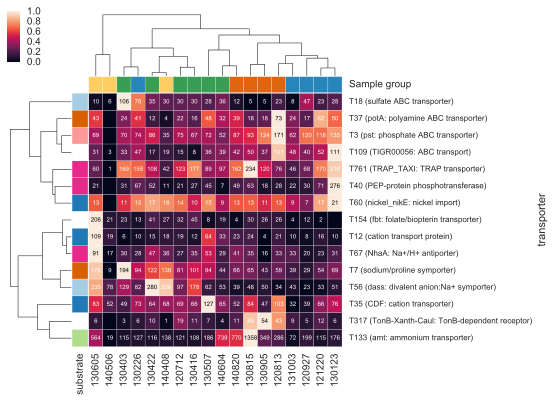

In [30]:
# Get transporters with an adjusted p-value < 0.05 in at least one of the Dseq2 comparisons
trans = set(mt_deseq.loc[mt_deseq.p_total_adj<0.05].index)
# Generate the data for plotting
clust_data = mt_bac_select_transcov.loc[trans][mt_groups.index]
clust_data = clust_data[mt_sample_order]

# Cluster transporters
row_linkage = linkage(pdist(clust_data, metric="correlation"), metric="correlation", method="complete")

# Annotate rows with the category legend colors
row_cols = pd.Series([mt_bac_select_transcov.loc[t,"substrate_category"] for t in trans],index=trans).map(cat_lut)
row_cols.name="substrate"

# Plot the clustermap
mt_ax = sns.clustermap(clust_data,method="complete",metric="correlation",standard_scale=0, col_cluster=True, row_linkage=row_linkage,
               col_colors=mt_groupcols, row_colors=row_cols, figsize=(6,6),linewidths=0.2)
# Rotate the transporter labels
plt.setp(mt_ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
# Annotate the clustermap to add the percentage values to cells
a,data_norm = annotate_clustermap(ax=mt_ax, dec=0)
# Change transporter labels to include the second category substrate
ticklocs = []
ticklabels = []
for i,item in enumerate(a.index):
    ticklocs.append(i+0.5)
    ticklabels.append("{} ({})".format(item,mt_bac_select_transcov.loc[item,"name"]))
mt_ax.ax_heatmap.yaxis.set_ticks(ticklocs)
mt_ax.ax_heatmap.yaxis.set_ticklabels(ticklabels,fontsize=8);
plt.savefig("results/figures/mt_deseq_clustermap.png",dpi=300,bbox_inches="tight")

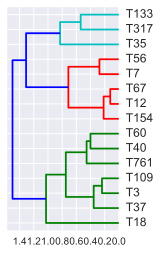

In [31]:
threshold = 1.2
g = pd.DataFrame(fcluster(row_linkage,criterion="distance",t=threshold),index=clust_data.index, columns=["group"])
plt.figure(figsize=(2,4))
dendrogram(row_linkage, color_threshold=threshold, orientation="left", labels=clust_data.index);

In [32]:
# Extract top 3 most abundant transporters per group
mt_plot_heat_clust = {}
for tg in g["group"].unique():
    tmp = clust_data.loc[g.loc[g["group"] == tg].index]
    mt_plot_heat_clust[tg] = list(tmp.mean(axis=1).sort_values(ascending=False).head(3).index)

In [33]:
mt_bac_select_fam_sum = mt_bac_select_transcov_genes.groupby(["fam","transporter","order"]).sum().reset_index()
mt_bac_select_trans_tax_mean = mt_bac_select_fam_sum.groupby(["transporter","order"]).mean().reset_index()

In [34]:
# Set cluster specific top 10 taxa
mt_plot_heat_clust_taxdict = {}
mt_plot_heat_clust_alltaxa = []
for clust in mt_plot_heat_clust.keys():
    # Get transporters for cluster
    transporters = mt_plot_heat_clust[clust]
    # Get summed taxonomic abundance for transporters
    r = mt_bac_select_trans_tax_mean.loc[mt_bac_select_trans_tax_mean.transporter.isin(transporters)]
    # Calculate mean abundance of taxa across all transporters and across all samples
    # Sort and take top 10
    _taxa = list(r.groupby("order").mean().mean(axis=1).sort_values(ascending=False).head(10).index)
    mt_plot_heat_clust_taxdict[clust] = _taxa
    mt_plot_heat_clust_alltaxa+=_taxa
    mt_plot_heat_clust_alltaxa = list(set(mt_plot_heat_clust_alltaxa))
len(mt_plot_heat_clust_alltaxa)

17

In [35]:
mt_taxcolors = {}
mt_taxhatches = {}
mt_missing = []
for taxa in mt_plot_heat_clust_alltaxa:
    try: 
        mt_taxcolors[taxa] = mg_taxcolors[taxa]
        mt_taxhatches[taxa] = mg_taxhatches[taxa]
    except KeyError: mt_missing.append(taxa)

In [36]:
mt_missingcolors = dict(zip(mt_missing,sns.color_palette("Set2",3)))
for taxa in mt_missing: mt_taxcolors[taxa] = mt_missingcolors[taxa]

In [37]:
mt_colormap = {}
patterns = ('----', '////', '\\\\', '....')
mt_taxhatches = {}
i = 0
for tax in sorted(mt_taxcolors.keys()):
    try:
        patterns[i]
    except IndexError:
        i = 0
    mt_taxhatches[tax] = patterns[i]
    c = ",".join(str(x) for x in mt_taxcolors[tax])
    mt_colormap[c] = tax
    i+=1

In [38]:
fig,axes = plt.subplots(ncols=3,nrows=3,figsize=(12,6), sharex=False)
for row,group in enumerate(sorted(mt_plot_heat_clust.keys())):
    _taxa = mt_plot_heat_clust_taxdict[group]
    row_axes = axes[row]
    transporters = mt_plot_heat_clust[group]
    r = mt_bac_select_trans_tax_mean.loc[mt_bac_select_trans_tax_mean.transporter.isin(transporters)]
    r = r.loc[r["order"].isin(_taxa)]

    for col,t in enumerate(r.transporter.unique()):
        axis = row_axes[col]
        rt = r.loc[r.transporter==t]
        rt = rt.groupby("order").sum()
        rt = rt.reindex(_taxa, fill_value=0)
        rt.sort_index(inplace=True)
        # Reorder samples by sample group
        rt = rt.loc[:,mt_sample_order]
        ax_colors = [mt_taxcolors[i] for i in rt.index]
        ax = rt.T.plot(kind="bar",stacked=True, legend=None, ax=axis, color=ax_colors)

        for p in ax.patches:
            c = ",".join([str(x) for x in list(p.properties()["fc"])[0:-1]])
            p.set_hatch(mt_taxhatches[mt_colormap[c]])
        ax.set_title("{} - {}".format(t,transinfo.loc[transinfo.transporter==t,"name"].values[0]), fontdict={'fontsize':6})
        ax.tick_params(axis='both', which='major', labelsize=6)
    row_axes[-1].legend(loc=2,prop={'size': 6}, bbox_to_anchor=(1,1))
    add_xtick_colors(row_axes, mt_groupcols)
plt.subplots_adjust(right=0.8,wspace=0.2,hspace=0.5)
plt.savefig("results/figures/mt_deseq_taxpanels.png",dpi=300,bbox_to_inches="tight")
plt.close()

### Plot deseq2 log fold change

In [42]:
def process_deseq_for_plotting(df,transinfo):
    df_sig = df.loc[df.p_total_adj<0.05]
    df_sig_info = pd.merge(transinfo,df_sig,left_on="transporter",right_index=True)
    #df_sig_info["transporter"] = df_sig_info.index
    return df_sig_info

Here we plot the log2 fold change for transporters that differ significantly in abundance between the sample groups.

In [264]:
mg_select_transcov = pd.read_table("results/mg/select_trans.tpm.tsv")
mg_deseq = pd.read_table("results/mg/deseq2.tab", index_col=7)
mg_deseq_sig_info = process_deseq_for_plotting(mg_deseq,transinfo)
mt_select_transcov = pd.read_table("results/mt/select_trans.tpm.tsv")
mt_deseq = pd.read_table("results/mt/deseq2.tab", index_col=7)
mt_deseq_sig_info = process_deseq_for_plotting(mt_deseq,transinfo)

Read the DEseq2 results generated by [run_deseq2](run_deseq2.ipynb).

In [229]:
def get_bar_colors(rc):
    bar_colors = []
    for t in rc.index:
        category = transinfo.loc[transinfo.transporter==t,"substrate_category"].values[0]
        bar_colors.append(cat_lut[category])
    return bar_colors

In [198]:
def plot_substrate_bar(df, group, axis):
    # Get all comparisons where a transporter has a higher log2FoldChange in the group
    _df_up1 = df.loc[(df.groups.str.contains("{} vs ".format(group)))&(df.log2FoldChange>0)&(df.substrate_category.isin(cats))]
    # Get all comparisons where a transporter has a lower log2FoldChange in another group
    _df_up2 = df.loc[(df.groups.str.contains(" vs {}".format(group)))&(df.log2FoldChange<0)&(df.substrate_category.isin(cats))]
    # Concatenate the two dataframes
    _df_up = pd.concat([_df_up1,_df_up2])
    # Select only the first of each unique transporter, groupby substrate category and count
    _df_up = _df_up.groupby("transporter").first().groupby("substrate_category").count().iloc[:,0]

    # Do the same as above but for 'down-regulated' transporters
    _df_down1 = df.loc[(df.groups.str.contains("{} vs ".format(group)))&(df.log2FoldChange<0)&(df.substrate_category.isin(cats))]
    _df_down2 = df.loc[(df.groups.str.contains(" vs {}".format(group)))&(df.log2FoldChange>0)&(df.substrate_category.isin(cats))]
    _df_down = pd.concat([_df_down1,_df_down2])
    _df_down = _df_down.groupby("transporter").first().groupby("substrate_category").count().iloc[:,0]
    _df = pd.concat([_df_down,_df_up],axis=1)
    _df.columns = ["-","+"]
    ax = _df.T.plot(kind="bar", stacked=True, color=[cat_lut[x] for x in _df.index], ax=axis, legend=None)
    return ax

For each group comparison plot the log2FoldChange of transporters that differ significantly between the groups. The barplot on the diagonal shows a summary of number of transporters with a lower ('-') or higher ('+') log2FoldChange for that group in each substrate category.

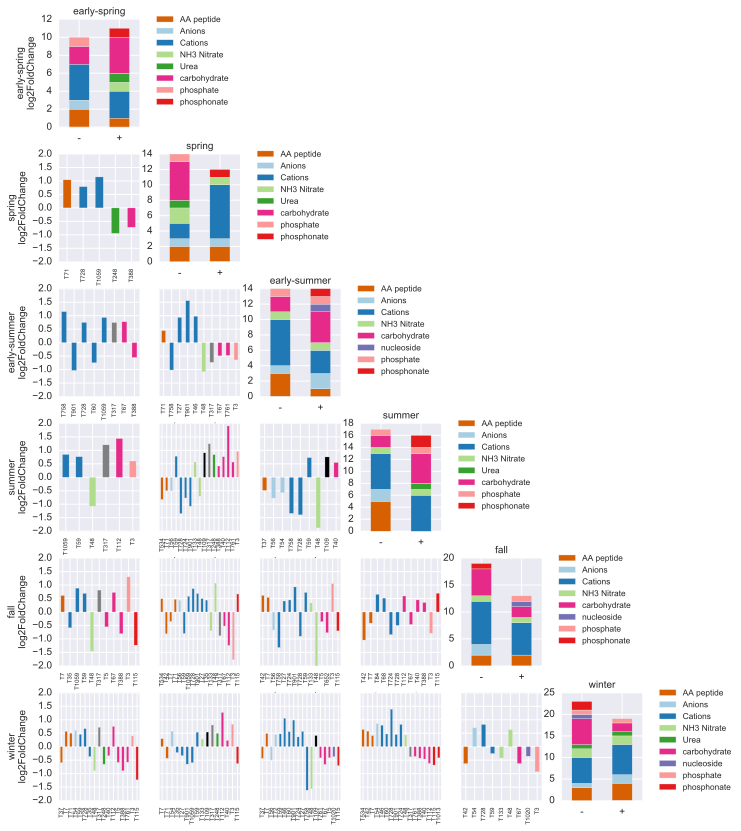

In [278]:
#TODO: Perhaps plot all comparisons and the summary in the right margin
fig, axes = plt.subplots(ncols=6, nrows=6, figsize=(12,14),sharex=False)

for i, mg_group in enumerate(["early-spring","spring","early-summer","summer","fall","winter"]):
    row_axes = axes[i]
    for j, mg_group2 in enumerate(["early-spring","spring","early-summer","summer","fall","winter"]):
        if mg_group == mg_group2:
            bar_ax = plot_substrate_bar(mg_deseq_sig_info, mg_group, row_axes[j])
            bar_ax.set_title(mg_group, fontdict={'fontsize': 10})
            bar_ax.set_xlabel("")
            bar_ax.legend(bbox_to_anchor=(2.2,1.1), fontsize = 'x-small')
            row_axes[j].set_xlabel("")
            row_axes[j].set_xticklabels(row_axes[j].get_xticklabels(),rotation=0)
            for ax in row_axes[j+1:]:
                ax.axis('off')
            break
        comp1 = "{} vs {}".format(mg_group, mg_group2)
        comp2 = "{} vs {}".format(mg_group2, mg_group)
        r = mg_deseq_sig_info.loc[mg_deseq_sig_info.groups.isin([comp1,comp2])]
        rc = r.loc[:,["transporter","log2FoldChange"]]
        rc = rc.groupby("transporter").sum()
        rc_info = transinfo.loc[transinfo.transporter.isin(rc.index)]
        rc = rc.loc[rc_info.sort_values("substrate_category").transporter]
        bar_colors = get_bar_colors(rc)
        rc.plot(kind="bar",ax=row_axes[j], color=bar_colors, legend=None)
        row_axes[j].set_xticklabels(row_axes[j].get_xticklabels(), fontdict={'fontsize': 6})
        row_axes[j].set_ylim(-2,2)
        if j>0: 
            row_axes[j].set_yticklabels("")
    row_axes[0].set_ylabel("{}\nlog2FoldChange".format(mg_group), fontdict={'fontsize': 10})
    for ax in row_axes:
        ax.set_xlabel("")
plt.subplots_adjust(right=0.8,wspace=0.25,hspace=0.25)
plt.savefig("results/figures/mg_deseq_foldchange.png", bbox_inches="tight", dpi=300)

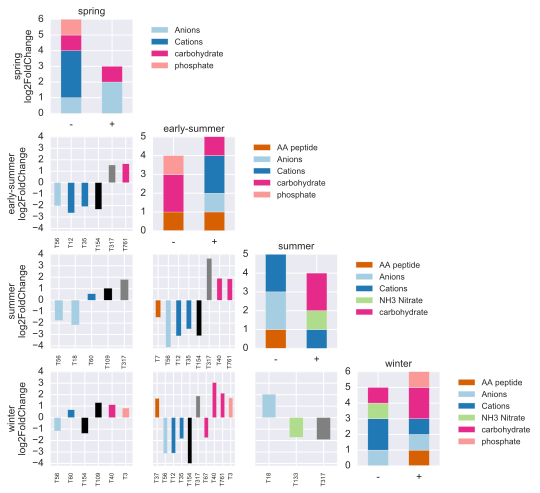

In [286]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(8,8),sharex=False)

for i, mt_group in enumerate(["spring","early-summer","summer","winter"]):
    row_axes = axes[i]
    for j, mt_group2 in enumerate(["spring","early-summer","summer","winter"]):
        if mt_group == mt_group2:
            bar_ax = plot_substrate_bar(mt_deseq_sig_info, mt_group, row_axes[j])
            bar_ax.set_title(mt_group, fontdict={'fontsize': 10})
            bar_ax.set_xlabel("")
            bar_ax.legend(bbox_to_anchor=(2.2,1), fontsize = 'x-small')
            row_axes[j].set_xlabel("")
            row_axes[j].set_xticklabels(row_axes[j].get_xticklabels(),rotation=0)
            for ax in row_axes[j+1:]:
                ax.axis('off')
            break
        comp1 = "{} vs {}".format(mt_group, mt_group2)
        comp2 = "{} vs {}".format(mt_group2, mt_group)
        r = mt_deseq_sig_info.loc[mt_deseq_sig_info.groups.isin([comp1,comp2])]
        rc = r.loc[:,["transporter","log2FoldChange"]]
        rc = rc.groupby("transporter").sum()
        rc_info = transinfo.loc[transinfo.transporter.isin(rc.index)]
        rc = rc.loc[rc_info.sort_values("substrate_category").transporter]
        bar_colors = get_bar_colors(rc)
        rc.plot(kind="bar",ax=row_axes[j], color=bar_colors, legend=None)
        row_axes[j].set_xticklabels(row_axes[j].get_xticklabels(), fontdict={'fontsize': 6})
        row_axes[j].set_ylim(-4.2,4)
        if j>0: 
            row_axes[j].set_yticklabels("")
    row_axes[0].set_ylabel("{}\nlog2FoldChange".format(mt_group), fontdict={'fontsize': 10})
    for ax in row_axes:
        ax.set_xlabel("")
plt.subplots_adjust(right=0.8,wspace=0.25,hspace=0.25)
plt.savefig("results/figures/mt_deseq_foldchange.png", bbox_inches="tight", dpi=300)